In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
import datetime
import kaleido
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import os
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pyalex
from pyalex import Authors, Concepts, Institutions, Works
import pickle
import seaborn as sns
from tqdm.notebook import tqdm
import xarray as xr

from researcher_impact.plotting import set_default_fig_layout
from researcher_impact.processors import OpenAlexProcessor
from researcher_impact.pyalex_utils import get_entity_name, merge_pages, merge_sample
from researcher_impact.regression import fit_linear_regression, predict

In [3]:
# Number of years after publication year to count citations
CITATION_YEAR_BOUND = 3

In [4]:
# Create a random number generator, with a fixed random seed for reproducibility
SEED = 20230105
rng = default_rng(seed=SEED)

In [5]:
# The polite pool has much faster and more consistent response times. To get into the polite pool, you set your email:
pyalex.config.email = "ben@epochai.org"

In [6]:
# Configure numpy to display numbers in scientific notation
np.set_printoptions(formatter={'float': '{: .2e}'.format})

In [7]:
# Apply the default theme
sns.set_theme()

In [8]:
# Location to save data and results
data_file_location = 'data/'
os.makedirs(data_file_location, exist_ok=True)

result_file_location = 'results/'
os.makedirs(result_file_location, exist_ok=True)

# Gather raw data

In [9]:
# From institutions.ipynb
selected_institution_ids = [
    "https://openalex.org/I1291425158",  # Google (United States)
    "https://openalex.org/I4210113297",  # Google (United Kingdom)
    "https://openalex.org/I4210100430",  # Google (Switzerland)
    "https://openalex.org/I4210148186",  # Google (Canada)
    "https://openalex.org/I4210117425",  # Google (Israel)
    "https://openalex.org/I4210131802",  # Google (Ireland)
    "https://openalex.org/I4210090411",  # DeepMind (United Kingdom)
    "https://openalex.org/I2252078561",  # Meta (Israel)
    "https://openalex.org/I4210114444",  # Meta (United States)
    "https://openalex.org/I4210111288",  # Meta (United Kingdom)
    "https://openalex.org/I1290206253",  # Microsoft (United States)
    "https://openalex.org/I4210164937",  # Microsoft Research (United Kingdom)
    "https://openalex.org/I4210113369",  # Microsoft Research Asia (China)
    "https://openalex.org/I4210124949",  # Microsoft Research (India)
    "https://openalex.org/I4210105678",  # Microsoft (Finland)
    "https://openalex.org/I4210087053",  # Microsoft (Germany)
    "https://openalex.org/I4210125051",  # Microsoft (Israel)
    "https://openalex.org/I4210162141",  # Microsoft (India)
    "https://openalex.org/I4210086099",  # Microsoft (Brazil)
    "https://openalex.org/I4210153468",  # Microsoft (Canada)
    "https://openalex.org/I4210161634",  # Microsoft (France)
    "https://openalex.org/I4210110431",  # Microsoft (Netherlands)
    "https://openalex.org/I4210099966",  # Microsoft (Denmark)
    "https://openalex.org/I4210108625",  # Microsoft (United Kingdom)
    "https://openalex.org/I4210135422",  # Microsoft (Norway)
    "https://openalex.org/I4210139986",  # Microsoft (Switzerland)
    "https://openalex.org/I4210109507",  # Microsoft (Ireland)
    "https://openalex.org/I4210092974",  # Microsoft (Portugal)
    "https://openalex.org/I4210151458",  # Microsoft (Belgium)
    "https://openalex.org/I4210161460",  # OpenAI (United States)
    "https://openalex.org/I45928872",  # Alibaba Group (China)
    "https://openalex.org/I4210095624",  # Alibaba Group (United States)
    "https://openalex.org/I4210086143",  # Alibaba Group (Cayman Islands)
    "https://openalex.org/I1304085615",  # Nvidia (United Kingdom)
    "https://openalex.org/I4210127875",  # Nvidia (United States)
    "https://openalex.org/I98301712",  # Baidu (China)
    "https://openalex.org/I1311688040",  # Amazon (United States)
    "https://openalex.org/I4210089985",  # Amazon (Germany)
    "https://openalex.org/I4210123934",  # Amazon (United Kingdom)
    "https://openalex.org/I2250653659",  # Tencent (China)
    "https://openalex.org/I4210103558",  # Tencent Healthcare (China)
]
len(selected_institution_ids)

41

In [10]:
selected_institutions_text = """
"https://openalex.org/I1291425158",  # Google (United States)
"https://openalex.org/I4210113297",  # Google (United Kingdom)
"https://openalex.org/I4210100430",  # Google (Switzerland)
"https://openalex.org/I4210148186",  # Google (Canada)
"https://openalex.org/I4210117425",  # Google (Israel)
"https://openalex.org/I4210131802",  # Google (Ireland)
"https://openalex.org/I4210090411",  # DeepMind (United Kingdom)
"https://openalex.org/I2252078561",  # Meta (Israel)
"https://openalex.org/I4210114444",  # Meta (United States)
"https://openalex.org/I4210111288",  # Meta (United Kingdom)
"https://openalex.org/I1290206253",  # Microsoft (United States)
"https://openalex.org/I4210164937",  # Microsoft Research (United Kingdom)
"https://openalex.org/I4210113369",  # Microsoft Research Asia (China)
"https://openalex.org/I4210124949",  # Microsoft Research (India)
"https://openalex.org/I4210105678",  # Microsoft (Finland)
"https://openalex.org/I4210087053",  # Microsoft (Germany)
"https://openalex.org/I4210125051",  # Microsoft (Israel)
"https://openalex.org/I4210162141",  # Microsoft (India)
"https://openalex.org/I4210086099",  # Microsoft (Brazil)
"https://openalex.org/I4210153468",  # Microsoft (Canada)
"https://openalex.org/I4210161634",  # Microsoft (France)
"https://openalex.org/I4210110431",  # Microsoft (Netherlands)
"https://openalex.org/I4210099966",  # Microsoft (Denmark)
"https://openalex.org/I4210108625",  # Microsoft (United Kingdom)
"https://openalex.org/I4210135422",  # Microsoft (Norway)
"https://openalex.org/I4210139986",  # Microsoft (Switzerland)
"https://openalex.org/I4210109507",  # Microsoft (Ireland)
"https://openalex.org/I4210092974",  # Microsoft (Portugal)
"https://openalex.org/I4210151458",  # Microsoft (Belgium)
"https://openalex.org/I4210161460",  # OpenAI (United States)
"https://openalex.org/I45928872",  # Alibaba Group (China)
"https://openalex.org/I4210095624",  # Alibaba Group (United States)
"https://openalex.org/I4210086143",  # Alibaba Group (Cayman Islands)
"https://openalex.org/I1304085615",  # Nvidia (United Kingdom)
"https://openalex.org/I4210127875",  # Nvidia (United States)
"https://openalex.org/I98301712",  # Baidu (China)
"https://openalex.org/I1311688040",  # Amazon (United States)
"https://openalex.org/I4210089985",  # Amazon (Germany)
"https://openalex.org/I4210123934",  # Amazon (United Kingdom)
"https://openalex.org/I2250653659",  # Tencent (China)
"https://openalex.org/I4210103558",  # Tencent Healthcare (China)
"""

# Map each institution id to the first word after the comment
institution_aliases = {}
for line in selected_institutions_text.splitlines()[1:]:
    institution_id = line.split(",")[0].strip('"')
    institution_name = line.split("#")[1].strip()
    institution_alias = institution_name.split(" ")[0].strip()
    institution_aliases[institution_id] = institution_alias
institution_aliases

{'https://openalex.org/I1291425158': 'Google',
 'https://openalex.org/I4210113297': 'Google',
 'https://openalex.org/I4210100430': 'Google',
 'https://openalex.org/I4210148186': 'Google',
 'https://openalex.org/I4210117425': 'Google',
 'https://openalex.org/I4210131802': 'Google',
 'https://openalex.org/I4210090411': 'DeepMind',
 'https://openalex.org/I2252078561': 'Meta',
 'https://openalex.org/I4210114444': 'Meta',
 'https://openalex.org/I4210111288': 'Meta',
 'https://openalex.org/I1290206253': 'Microsoft',
 'https://openalex.org/I4210164937': 'Microsoft',
 'https://openalex.org/I4210113369': 'Microsoft',
 'https://openalex.org/I4210124949': 'Microsoft',
 'https://openalex.org/I4210105678': 'Microsoft',
 'https://openalex.org/I4210087053': 'Microsoft',
 'https://openalex.org/I4210125051': 'Microsoft',
 'https://openalex.org/I4210162141': 'Microsoft',
 'https://openalex.org/I4210086099': 'Microsoft',
 'https://openalex.org/I4210153468': 'Microsoft',
 'https://openalex.org/I4210161634

In [11]:
institution_query = "|".join(selected_institution_ids)
institution_query

'https://openalex.org/I1291425158|https://openalex.org/I4210113297|https://openalex.org/I4210100430|https://openalex.org/I4210148186|https://openalex.org/I4210117425|https://openalex.org/I4210131802|https://openalex.org/I4210090411|https://openalex.org/I2252078561|https://openalex.org/I4210114444|https://openalex.org/I4210111288|https://openalex.org/I1290206253|https://openalex.org/I4210164937|https://openalex.org/I4210113369|https://openalex.org/I4210124949|https://openalex.org/I4210105678|https://openalex.org/I4210087053|https://openalex.org/I4210125051|https://openalex.org/I4210162141|https://openalex.org/I4210086099|https://openalex.org/I4210153468|https://openalex.org/I4210161634|https://openalex.org/I4210110431|https://openalex.org/I4210099966|https://openalex.org/I4210108625|https://openalex.org/I4210135422|https://openalex.org/I4210139986|https://openalex.org/I4210109507|https://openalex.org/I4210092974|https://openalex.org/I4210151458|https://openalex.org/I4210161460|https://o

In [12]:
concept_ids = [
    'https://openalex.org/C154945302',  # Artificial intelligence
    'https://openalex.org/C119857082',  # Machine learning
]

In [13]:
concept_query = "|".join(concept_ids)
concept_query

'https://openalex.org/C154945302|https://openalex.org/C119857082'

In [68]:
n_max = int(1e6)
works_instance = Works()
works = merge_pages(
    works_instance \
        .filter(authorships={"institutions": {"id": institution_query}}) \
        .filter(concepts={"id": concept_query}) \
        .filter(from_publication_date="2010-01-01") \
        .filter(to_publication_date="2023-06-15") \
        .filter(cited_by_count=">9") \
        .paginate(per_page=200, n_max=n_max)
)
assert len(works) < n_max
len(works)

94page [02:22,  1.52s/page]


18679

In [ ]:
# Save to avoid fetching every time
timestamp = datetime.datetime.now()
with open(data_file_location + f"selected_institution_works_openalex_{timestamp.strftime('%Y-%m-%d_%H-%M-%S')}", "wb") as f:
    obj = {
        "params": works_instance.params,  # for reproducibility
        "works": works,
    }
    pickle.dump(obj, f)

In [16]:
with open(data_file_location + "selected_institution_works_openalex_2023-06-15_18-01-45", "rb") as f:
    works_obj = pickle.load(f)
    works = works_obj["works"]
len(works)

19988

In [69]:
# There is some duplication
len(set([work['id'] for work in works]))

17969

In [18]:
deduplicated_works = list()
unique_work_ids = set()
for work in works:
    if work['id'] not in unique_work_ids:
        deduplicated_works.append(work)
        unique_work_ids.add(work['id'])
len(deduplicated_works)

17957

In [19]:
works = deduplicated_works

# Data processing

In [152]:
processor = OpenAlexProcessor(works, selected_institution_ids, institution_aliases, citation_year_bound=CITATION_YEAR_BOUND)

In [153]:
processor.process_works()

In [154]:
publication_years = list(range(2010, 2022 + 1))

## [TODO] Whole field

In [ ]:
ml_concept = Concepts()["https://openalex.org/C119857082"]
total_ml_citations = 0
for concept in [ml_concept]:
    for year_counts in concept['counts_by_year']:
        if year_counts['year'] in publication_years:
            total_ml_citations += year_counts['cited_by_count']
total_ml_citations

In [ ]:
ml_concept['cited_by_count']

In [ ]:
ml_concept['works_count']

In [ ]:
ai_concept_cited_by_count = xr.DataArray(np.zeros(len(publication_years)), dims=['year'], coords={'year': publication_years})
for year_counts in ai_concept['counts_by_year']:
    year = year_counts['year']
    if year in publication_years:
        ai_concept_cited_by_count.loc[year] = year_counts['cited_by_count']
ai_concept_cited_by_count

In [ ]:
total_citations = defaultdict(int)
for work in works:
    total_citations[work['publication_year']] += work['cited_by_count']
total_citations

## Selected institutions

In [155]:
institution_author_data = processor.get_author_data()
institution_author_data

defaultdict(<function researcher_impact.processors.OpenAlexProcessor.deduplicate_authors.<locals>.<lambda>()>,
            {'Microsoft': defaultdict(set,
                         {2016: {'https://openalex.org/A1048906628',
                           'https://openalex.org/A130871852',
                           'https://openalex.org/A131194035',
                           'https://openalex.org/A1487353611',
                           'https://openalex.org/A1520953178',
                           'https://openalex.org/A1553325704',
                           'https://openalex.org/A1598186712',
                           'https://openalex.org/A1812361008',
                           'https://openalex.org/A1823475869',
                           'https://openalex.org/A1843571100',
                           'https://openalex.org/A1886754024',
                           'https://openalex.org/A1963524793',
                           'https://openalex.org/A1964797733',
                       

In [156]:
institution_author_name_data = processor.get_author_name_data()

In [157]:
institution_author_counts = processor.get_author_counts()

In [158]:
institution_author_counts

{'Microsoft': <xarray.DataArray (year: 14)>
 array([ 5.42e+02,  5.50e+02,  5.95e+02,  6.29e+02,  6.53e+02,  5.93e+02,
         5.41e+02,  5.56e+02,  6.75e+02,  7.31e+02,  8.14e+02,  5.38e+02,
         1.45e+02,  8.00e+00])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'Meta': <xarray.DataArray (year: 14)>
 array([ 5.00e+00,  3.20e+01,  1.70e+01,  4.20e+01,  5.20e+01,  8.40e+01,
         1.01e+02,  1.46e+02,  2.58e+02,  4.81e+02,  5.82e+02,  4.59e+02,
         6.80e+01,  2.00e+00])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'Google': <xarray.DataArray (year: 14)>
 array([ 1.84e+02,  2.10e+02,  2.45e+02,  2.57e+02,  2.85e+02,  4.25e+02,
         6.42e+02,  7.61e+02,  1.07e+03,  1.39e+03,  1.44e+03,  1.02e+03,
         3.23e+02,  3.00e+00])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'DeepMind': <xarray.DataArray (year: 10)>
 array([

In [159]:
institution_bounded_citations = processor.get_bounded_citations()

In [160]:
institution_bounded_citations

{'Microsoft': <xarray.DataArray (year: 14)>
 array([ 9.59e+03,  1.63e+04,  1.76e+04,  2.13e+04,  2.20e+04,  3.14e+04,
         5.38e+04,  3.68e+04,  3.59e+04,  4.23e+04,  3.15e+04,  1.59e+04,
         1.50e+03,  1.50e+01])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'Meta': <xarray.DataArray (year: 14)>
 array([ 5.30e+01,  8.82e+02,  6.53e+02,  1.17e+03,  3.21e+03,  1.86e+04,
         1.50e+04,  5.41e+04,  2.68e+04,  3.98e+04,  3.11e+04,  1.06e+04,
         1.24e+03,  2.00e+00])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'Google': <xarray.DataArray (year: 14)>
 array([ 2.99e+03,  4.84e+03,  5.68e+03,  1.00e+04,  1.93e+04,  4.02e+04,
         4.91e+04,  7.40e+04,  9.28e+04,  9.15e+04,  7.35e+04,  1.77e+04,
         2.07e+03,  4.00e+00])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'DeepMind': <xarray.DataArray (year: 10)>
 array([

In [161]:
institution_work_counts = processor.get_work_counts()

In [162]:
institution_work_counts

{'Microsoft': <xarray.DataArray (year: 14)>
 array([ 5.37e+02,  5.73e+02,  5.97e+02,  6.34e+02,  6.24e+02,  5.55e+02,
         5.56e+02,  6.01e+02,  6.98e+02,  7.11e+02,  6.65e+02,  3.93e+02,
         7.20e+01,  4.00e+00])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'Meta': <xarray.DataArray (year: 14)>
 array([ 6.00e+00,  1.60e+01,  2.00e+01,  3.10e+01,  3.60e+01,  8.40e+01,
         1.25e+02,  1.84e+02,  2.73e+02,  4.15e+02,  3.74e+02,  2.53e+02,
         2.30e+01,  1.00e+00])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'Google': <xarray.DataArray (year: 14)>
 array([ 1.48e+02,  1.72e+02,  1.83e+02,  2.11e+02,  2.47e+02,  3.18e+02,
         4.51e+02,  5.51e+02,  8.26e+02,  9.81e+02,  9.09e+02,  4.48e+02,
         8.80e+01,  1.00e+00])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'DeepMind': <xarray.DataArray (year: 10)>
 array([

In [163]:
institution_individual_bounded_citations = processor.get_individual_bounded_citations()

In [164]:
institution_individual_bounded_citations

{'Microsoft': array([27058,  1967,  1128, ...,     0,     3,     8]),
 'Meta': array([9041, 1181, 1234, ...,    1,    5,    2]),
 'Google': array([9041, 6643, 3383, ...,   10,   10,    4]),
 'DeepMind': array([3383,   64,   91,   47,   16,   10,   15,   13,   11,    9, 4584,
         549,  164,  467,  258,  188,  159,  167,   89,   92,   23,   41,
          27,   38,   36,   31,   29,   32,   25,   23,   34,   25,    2,
          15,   10,   11,   11,    9,    8, 9598, 1722, 1164,  626,  399,
         160,  130,   80,   73,   74,   68,   63,   54,   55,   39,   34,
          26,   32,   28,   29,   23,   24,   23,   22,   19,   20,   17,
          16,   14,   15,    9,   12,   13,   14,   13,   14,   12,   13,
          12,   11,   10,   10,   11,   12,   12,   12,   11,    9,   10,
          11,    9,    9,    9,    9,   10, 3158, 2170, 1153,  499,  375,
         292,  260,  266,  229,  185,  192,  190,  226,  122,  140,  120,
         129,  132,  104,  135,   95,  105,   89,   98,   

In [165]:
institution_works_per_author = {}
for ins, author_counts in institution_author_counts.items():
    institution_works_per_author[ins] = institution_work_counts[ins] / author_counts
institution_works_per_author

{'Microsoft': <xarray.DataArray (year: 14)>
 array([ 9.91e-01,  1.04e+00,  1.00e+00,  1.01e+00,  9.56e-01,  9.36e-01,
         1.03e+00,  1.08e+00,  1.03e+00,  9.73e-01,  8.17e-01,  7.30e-01,
         4.97e-01,  5.00e-01])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'Meta': <xarray.DataArray (year: 14)>
 array([ 1.20e+00,  5.00e-01,  1.18e+00,  7.38e-01,  6.92e-01,  1.00e+00,
         1.24e+00,  1.26e+00,  1.06e+00,  8.63e-01,  6.43e-01,  5.51e-01,
         3.38e-01,  5.00e-01])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'Google': <xarray.DataArray (year: 14)>
 array([ 8.04e-01,  8.19e-01,  7.47e-01,  8.21e-01,  8.67e-01,  7.48e-01,
         7.02e-01,  7.24e-01,  7.71e-01,  7.05e-01,  6.30e-01,  4.41e-01,
         2.72e-01,  3.33e-01])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'DeepMind': <xarray.DataArray (year: 10)>
 array([

In [166]:
institution_avg_bounded_citations = {}
for ins, citation_counts in institution_bounded_citations.items():
    institution_avg_bounded_citations[ins] = citation_counts / institution_work_counts[ins]
institution_avg_bounded_citations

{'Microsoft': <xarray.DataArray (year: 14)>
 array([ 1.79e+01,  2.84e+01,  2.95e+01,  3.36e+01,  3.53e+01,  5.65e+01,
         9.67e+01,  6.12e+01,  5.14e+01,  5.95e+01,  4.74e+01,  4.04e+01,
         2.08e+01,  3.75e+00])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'Meta': <xarray.DataArray (year: 14)>
 array([ 8.83e+00,  5.51e+01,  3.26e+01,  3.78e+01,  8.91e+01,  2.21e+02,
         1.20e+02,  2.94e+02,  9.80e+01,  9.60e+01,  8.32e+01,  4.17e+01,
         5.40e+01,  2.00e+00])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'Google': <xarray.DataArray (year: 14)>
 array([ 2.02e+01,  2.81e+01,  3.10e+01,  4.74e+01,  7.82e+01,  1.26e+02,
         1.09e+02,  1.34e+02,  1.12e+02,  9.33e+01,  8.09e+01,  3.94e+01,
         2.35e+01,  4.00e+00])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'DeepMind': <xarray.DataArray (year: 10)>
 array([

In [167]:
institution_bounded_citations_per_author = {}
for ins, citation_counts in institution_bounded_citations.items():
    institution_bounded_citations_per_author[ins] = citation_counts / institution_author_counts[ins]
institution_bounded_citations_per_author

{'Microsoft': <xarray.DataArray (year: 14)>
 array([ 1.77e+01,  2.96e+01,  2.96e+01,  3.39e+01,  3.37e+01,  5.29e+01,
         9.94e+01,  6.61e+01,  5.31e+01,  5.78e+01,  3.87e+01,  2.95e+01,
         1.03e+01,  1.88e+00])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'Meta': <xarray.DataArray (year: 14)>
 array([ 1.06e+01,  2.76e+01,  3.84e+01,  2.79e+01,  6.17e+01,  2.21e+02,
         1.48e+02,  3.70e+02,  1.04e+02,  8.28e+01,  5.34e+01,  2.30e+01,
         1.82e+01,  1.00e+00])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'Google': <xarray.DataArray (year: 14)>
 array([ 1.63e+01,  2.30e+01,  2.32e+01,  3.89e+01,  6.78e+01,  9.46e+01,
         7.64e+01,  9.73e+01,  8.66e+01,  6.58e+01,  5.10e+01,  1.74e+01,
         6.41e+00,  1.33e+00])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'DeepMind': <xarray.DataArray (year: 10)>
 array([

In [168]:
institution_avg_bounded_citations_per_author = {}
for ins, citation_counts in institution_avg_bounded_citations.items():
    institution_avg_bounded_citations_per_author[ins] = citation_counts / institution_author_counts[ins]
institution_avg_bounded_citations_per_author

{'Microsoft': <xarray.DataArray (year: 14)>
 array([ 3.29e-02,  5.16e-02,  4.95e-02,  5.35e-02,  5.41e-02,  9.53e-02,
         1.79e-01,  1.10e-01,  7.61e-02,  8.13e-02,  5.82e-02,  7.51e-02,
         1.43e-01,  4.69e-01])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'Meta': <xarray.DataArray (year: 14)>
 array([ 1.77e+00,  1.72e+00,  1.92e+00,  9.00e-01,  1.71e+00,  2.63e+00,
         1.18e+00,  2.01e+00,  3.80e-01,  2.00e-01,  1.43e-01,  9.09e-02,
         7.93e-01,  1.00e+00])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'Google': <xarray.DataArray (year: 14)>
 array([ 1.10e-01,  1.34e-01,  1.27e-01,  1.85e-01,  2.74e-01,  2.98e-01,
         1.69e-01,  1.77e-01,  1.05e-01,  6.71e-02,  5.61e-02,  3.88e-02,
         7.28e-02,  1.33e+00])
 Coordinates:
   * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023,
 'DeepMind': <xarray.DataArray (year: 10)>
 array([

In [56]:
total_author_counts = xr.DataArray(np.zeros(len(publication_years)), dims=['year'], coords={'year': publication_years})
for ins, author_counts in institution_author_counts.items():
    print(ins)
    print(author_counts)
    for count in author_counts:
        total_author_counts.loc[count.year] += count
    print(total_author_counts)
    print("====")

Meta
<xarray.DataArray (year: 13)>
array([ 6.00e+00,  3.30e+01,  2.20e+01,  4.90e+01,  7.50e+01,  1.67e+02,
        2.62e+02,  3.57e+02,  5.77e+02,  1.09e+03,  1.14e+03,  7.64e+02,
        7.30e+01])
Coordinates:
  * year     (year) int64 2010 2011 2012 2013 2014 ... 2018 2019 2020 2021 2022
<xarray.DataArray (year: 13)>
array([ 6.00e+00,  3.30e+01,  2.20e+01,  4.90e+01,  7.50e+01,  1.67e+02,
        2.62e+02,  3.57e+02,  5.77e+02,  1.09e+03,  1.14e+03,  7.64e+02,
        7.30e+01])
Coordinates:
  * year     (year) int64 2010 2011 2012 2013 2014 ... 2018 2019 2020 2021 2022
====
Google
<xarray.DataArray (year: 14)>
array([ 2.63e+02,  2.75e+02,  3.18e+02,  3.74e+02,  4.74e+02,  7.18e+02,
        1.27e+03,  1.42e+03,  2.52e+03,  2.94e+03,  2.84e+03,  1.60e+03,
        3.32e+02,  3.00e+00])
Coordinates:
  * year     (year) int64 2010 2011 2012 2013 2014 ... 2019 2020 2021 2022 2023


KeyError: "not all values found in index 'year'. Try setting the `method` keyword argument (example: method='nearest')."

## Sense checks

In [ ]:
Works().search("Attention is all you need").get()

In [ ]:
Works().search("Language models are few-shot learners").get()[0]

In [ ]:
Authors().search("Marcin Andrychowicz").get()

When the institution has not ID, perhaps we could include it if the alias is contained in the display_name?

In [169]:
num_works_with_missing_affiliation = 0
num_works_with_missing_affiliation_id = 0
for work in works:
    for authorship in work["authorships"]:
        if len(authorship["institutions"]) == 0:
            num_works_with_missing_affiliation += 1
            break
        if all([ins.get("id") is None for ins in authorship["institutions"]]):
            # Means there's a display name but no ID - I exclude these cases
            num_works_with_missing_affiliation_id += 1
            break
num_works_with_missing_affiliation, num_works_with_missing_affiliation_id

(975, 2147)

In [170]:
len(works)

18679

In [171]:
(num_works_with_missing_affiliation + num_works_with_missing_affiliation_id) / len(works)

0.16713956849938433

In [172]:
processor.author_id_to_name

defaultdict(<function researcher_impact.processors.OpenAlexProcessor.__init__.<locals>.<lambda>()>,
            {'Microsoft': defaultdict(dict,
                         {2016: {'https://openalex.org/A4344207660': 'Kaiming He',
                           'https://openalex.org/A4358260579': 'Xiangyu Zhang',
                           'https://openalex.org/A2119543935': 'Shaoqing Ren',
                           'https://openalex.org/A4358569165': 'Jian Sun',
                           'https://openalex.org/A4355241700': 'Xiaodong He',
                           'https://openalex.org/A4357333070': 'Nicolo Fusi',
                           'https://openalex.org/A700773976': 'Jennifer Listgarten',
                           'https://openalex.org/A4359087942': 'Ross Girshick',
                           'https://openalex.org/A4358654589': 'Jianfeng Gao',
                           'https://openalex.org/A4359235829': 'Li Deng',
                           'https://openalex.org/A2095316779': 'C

In [173]:
institution_author_name_data["OpenAI"][2018]

['Xue Bin Peng',
 'Phillip Isola',
 'Rafal Jozefowicz',
 'Josh Tobin',
 'Jonas Schneider',
 'Peter Welinder',
 'Jonathan Raiman',
 'Pieter Abbeel',
 'Bob McGrew',
 'Igor Mordatch',
 'Harrison Edwards',
 'Marcin Andrychowicz',
 'Wojciech Zaremba',
 'Alex K. Ray']

In [174]:
total_authors = 0
total_unique_authors = 0

for alias in set(institution_aliases.values()):
    ins_authors = 0
    ins_unique_authors = 0
    for year in publication_years:
        author_names_example = institution_author_name_data[alias][year]
        ins_authors += len(author_names_example)
        ins_unique_authors += len(set(author_names_example))
        total_authors += len(author_names_example)
        total_unique_authors += len(set(author_names_example))
    print(f"{alias}: {ins_authors} authors, {ins_unique_authors} unique authors ({100 * (ins_authors - ins_unique_authors) / ins_authors:.2f}% duplication)")
total_authors, total_unique_authors

Amazon: 1284 authors, 1284 unique authors (0.00% duplication)
Microsoft: 7562 authors, 7562 unique authors (0.00% duplication)
Nvidia: 921 authors, 921 unique authors (0.00% duplication)
OpenAI: 80 authors, 80 unique authors (0.00% duplication)
Tencent: 1360 authors, 1360 unique authors (0.00% duplication)
DeepMind: 1021 authors, 1021 unique authors (0.00% duplication)
Alibaba: 1571 authors, 1571 unique authors (0.00% duplication)
Meta: 2327 authors, 2327 unique authors (0.00% duplication)
Baidu: 1105 authors, 1105 unique authors (0.00% duplication)
Google: 8252 authors, 8252 unique authors (0.00% duplication)


(25483, 25483)

# Regression

## Citation-weighted publications in a year, as a function of cumulative citation-weighted publications in the whole field, and the number of researchers in major corporations

I will define the "number of researchers in major corporations" as the total number of authors across the selected institutions, in each year.
So if you were affiliated with one of the selected institutions on a work that was published in a given year, then you are counted in the "number of researchers in major corporations" for that year.

In [ ]:
output_start_year = 2013
output_end_year = 2021
input_end_year = output_end_year - 1
input_start_year = output_start_year - 1

In [ ]:
num_researchers = total_author_counts.loc[input_start_year:input_end_year]
num_researchers = num_researchers.expand_dims(dim={'feature': ['num_researchers']}, axis=1)
num_researchers

Defining the "whole field" as just the set of works affiliated with the selected institutions.
Setting the citation weighting to just be the number of citations.

In [ ]:
field_citation_weighted_works = ai_concept_cited_by_count.loc[input_start_year:input_end_year]
field_citation_weighted_works = np.cumsum(field_citation_weighted_works)
field_citation_weighted_works = field_citation_weighted_works.expand_dims(dim={'feature': ['field_citation_weighted_works']}, axis=1)
field_citation_weighted_works

In [ ]:
# design_matrix = xr.concat([field_citation_weighted_works, num_researchers], dim='feature')
design_matrix = num_researchers
design_matrix

In [ ]:
citation_weighted_works = ai_concept_cited_by_count.loc[output_start_year:output_end_year]
citation_weighted_works

In [ ]:
est = fit_linear_regression(np.log10(design_matrix.data), np.log10(citation_weighted_works.data))
est.summary()

In [ ]:
est_exp = fit_linear_regression(design_matrix.data, np.log10(citation_weighted_works.data))
est_exp.summary()

In [ ]:
est_lin = fit_linear_regression(design_matrix.data, citation_weighted_works.data)
est_lin.summary()

In [ ]:
est_rand = fit_linear_regression(np.random.rand(len(num_researchers)), np.log10(citation_weighted_works.data))
est_rand.summary()

In [ ]:
est_year = fit_linear_regression(np.arange(output_start_year, output_end_year+1), np.log10(citation_weighted_works.data))
est_year.summary()

In [ ]:
citation_weighted_works_preds = predict(est, np.log10(design_matrix))
citation_weighted_works_preds

In [ ]:
citation_weighted_works_preds_year = predict(est_year, np.arange(output_start_year, output_end_year+1))
citation_weighted_works_preds_year

In [ ]:
fig = go.Figure()
# fig.add_trace(
#     go.Scatter(
#         x=num_researchers['year'],
#         y=np.log10(num_researchers.squeeze()),
#         name='log R: number of researchers',
#         mode='lines+markers',
#     ),
# )
# fig.add_trace(
#     go.Scatter(
#         x=field_citation_weighted_works['year'],
#         y=np.log10(field_citation_weighted_works.squeeze()),
#         name='log A: citation-weighted works (cumulative)',
#         mode='lines+markers',
#     ),
# )
fig.add_trace(
    go.Scatter(
        x=citation_weighted_works['year'],
        y=np.log10(citation_weighted_works.squeeze()),
        name='log \dot A: citation-weighted works (this year)',
        mode='lines+markers',
    ),
)
fig.add_trace(
    go.Scatter(
        x=citation_weighted_works['year'],
        y=citation_weighted_works_preds['mean'],
        name=f'Predicted: log \dot A = {est.params[0]:.2f} + {est.params[1]:.2f} log R',
        mode='lines+markers',
    ),
)

## Plot layout
dates = np.arange(2010, 2022 + 1)
y_ticks = np.arange(0, 101, 10)
y_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# set_default_fig_layout(fig, dates, dates, y_ticks, y_tick_text)

fig.update_layout(
    # title='Number of unique authors on AI papers',
    xaxis_title='Year',
    # yaxis_title='Number of unique authors',
)
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
# fig.write_image(result_file_location + 'field_citations_regression_researchers_only.png', scale=2)

## Show plot
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=citation_weighted_works['year'],
        y=np.log10(citation_weighted_works.squeeze()),
        name='log \dot A: citation-weighted works (this year)',
        mode='lines+markers',
    ),
)
fig.add_trace(
    go.Scatter(
        x=citation_weighted_works['year'],
        y=citation_weighted_works_preds_year['mean'],
        name=f'Predicted: log \dot A = {est_year.params[0]:.2f} + {est_year.params[1]:.2f} t',
        mode='lines+markers',
    ),
)

## Plot layout
dates = np.arange(2010, 2022 + 1)
y_ticks = np.arange(0, 101, 10)
y_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# set_default_fig_layout(fig, dates, dates, y_ticks, y_tick_text)

fig.update_layout(
    # title='Number of unique authors on AI papers',
    xaxis_title='Year',
    # yaxis_title='Number of unique authors',
)
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
# fig.write_image(result_file_location + 'num_authors_google_oai_dm.png', scale=2)

## Show plot
fig.show()

## Citation-weighted publications for the institution next year, as a function of this year's cumulative citation-weighted publications in the whole field, and the number of researchers at the company

In [ ]:
institution_fits = {}
institution_preds = {}
for ins, author_count in institution_author_count.items():
    ins_num_researchers = institution_author_count[ins]
    # Check bounds
    if ins_num_researchers['year'].min() > input_start_year:
        start_year = ins_num_researchers['year'].min()
    elif input_start_year not in ins_num_researchers['year']:  # DeepMind special case
        start_year = 2013
    else:
        start_year = input_start_year
    if ins_num_researchers['year'].max() < input_end_year:
        end_year = ins_num_researchers['year'].max()
    else:
        end_year = input_end_year

    ins_num_researchers = ins_num_researchers.loc[start_year:end_year]
    ins_num_researchers = ins_num_researchers.expand_dims(dim={'feature': ['num_researchers']}, axis=1)

    ins_design_matrix = ins_num_researchers

    # ins_citation_weighted_works = institution_new_citations[ins].loc[start_year+1:end_year+1]
    ins_citation_weighted_works = institution_cited_by_counts[ins].loc[start_year:end_year]

    institution_fits[ins] = fit_linear_regression(np.log10(ins_design_matrix.data), np.log10(ins_citation_weighted_works.data))
    institution_preds[ins] = predict(institution_fits[ins], np.log10(ins_design_matrix))


In [ ]:
for ins, ins_est in institution_fits.items():
    print(f"{Institutions()[ins]['display_name']}: R^2={ins_est.rsquared:.2f}, w1={ins_est.params[1]:.2f}")

In [ ]:
regression_excluded_institutions = [
    "https://openalex.org/I4210090411",  # DeepMind
    "https://openalex.org/I4210161460",  # OpenAI
]

In [ ]:
fig = make_subplots(
    rows=len(institution_fits) - len(regression_excluded_institutions),
    cols=1,
    subplot_titles=[Institutions()[ins]['display_name'] for ins in institution_fits.keys() if ins not in regression_excluded_institutions],
)

for i, ins in enumerate([k for k in institution_fits.keys() if k not in regression_excluded_institutions]):
    if ins in regression_excluded_institutions:
        continue
    
    ins_num_researchers = institution_author_count[ins]
    # Check bounds
    if ins_num_researchers['year'].min() > input_start_year:
        start_year = ins_num_researchers['year'].min()
    elif input_start_year not in ins_num_researchers['year']:  # DeepMind special case
        start_year = 2013
    else:
        start_year = input_start_year
    if ins_num_researchers['year'].max() < input_end_year:
        end_year = ins_num_researchers['year'].max()
    else:
        end_year = input_end_year

    ins_num_researchers = ins_num_researchers.loc[start_year:end_year]
    # ins_num_researchers = ins_num_researchers.loc[input_start_year:input_end_year]
    # ins_citation_weighted_works = institution_new_citations[ins].loc[output_start_year:output_end_year]
    ins_citation_weighted_works = institution_cited_by_counts[ins].loc[start_year:end_year]

    ins_est = institution_fits[ins]
    ins_preds = institution_preds[ins]

    fig.add_trace(
        go.Scatter(
            x=ins_num_researchers,  # ins_citation_weighted_works['year'],
            y=ins_citation_weighted_works.squeeze(),
            mode='markers',
            line_color=plotly.colors.DEFAULT_PLOTLY_COLORS[0],
        ),
        row=i+1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(
            x=ins_num_researchers,  # ins_citation_weighted_works['year'],
            y=10**ins_preds['mean'],
            text=ins_citation_weighted_works['year'],
            mode='lines+markers',
            line_color=plotly.colors.DEFAULT_PLOTLY_COLORS[1],
        ),
        row=i+1,
        col=1,
    )

    fig.add_annotation(
        xref="x domain",
        yref="y domain",
        x=1,
        y=0,
        text=f'Fit: A = {10**ins_est.params[0]:.1e}*R^{ins_est.params[1]:.1f} (r^2={ins_est.rsquared:.2f})',
        showarrow=False,
        font=dict(
            # family="Courier New, monospace",
            # size=16,
            color=plotly.colors.DEFAULT_PLOTLY_COLORS[1],
        ),
        row=i+1,
        col=1, 
    )

## Plot layout
fig.update_xaxes(title_text="Number of unique authors on works published in year Y", row=5, col=1)
fig.update_yaxes(title_text="Citations in year Y+1, for works published in year Y", row=3, col=1)
fig.update_xaxes(type='log')
fig.update_yaxes(type='log')
fig.update_layout(
    autosize=False,
    width=800,
    height=1200,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)
fig.update_layout(
    showlegend=False,
)

## Save plot
fig.write_image(result_file_location + 'ins_citations_regression_same_year.png', scale=2)

## Show plot
fig.show()

# Plots

### Citation distribution

In [51]:
nrow = 2
ncol = 5
fig = fig = make_subplots(
    rows=nrow,
    cols=ncol,
    subplot_titles=[ins for ins in institution_individual_bounded_citations.keys()],
    shared_xaxes=True,
    shared_yaxes=True,
)

for i, (ins, cited_by_distribution) in enumerate(institution_individual_bounded_citations.items()):
    fig.add_trace(
        go.Histogram(
            x=np.log10(cited_by_distribution[cited_by_distribution > 0]),
            name=ins,
            histnorm='probability',
            xbins=dict(
                start=0,
                end=4,
                size=1,
            ),
            autobinx=False,
        ),
        row=(i // ncol) + 1,
        col=(i % ncol) + 1,
    )

fig.update_xaxes(
    tickmode='array',
    ticktext=["1-10", "10-100", "100-1k", "1k-10k"],
    tickvals=[0.5, 1.5, 2.5, 3.5],
)

# Update y-axis range for each row
for row in range(1, 3):
    fig.update_yaxes(range=[0, 1], row=row, col=1)

fig.update_yaxes(showticklabels=False)
for row in range(1, nrow+1):
    fig.update_yaxes(showticklabels=True, row=row, col=1)

fig.update_xaxes(title_text="Citations in publication year and the next 3 calendar years", row=2, col=3)
for row in range(1, nrow+1):
    fig.update_yaxes(title_text="Probability", row=row, col=1)

fig.update_layout(showlegend=False)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
fig.write_image(result_file_location + 'citation_histogram_3y.png', scale=2)

## Show plot
fig.show()

Text(0.5, 0, 'Number of citations in publication year and the next 3 years')

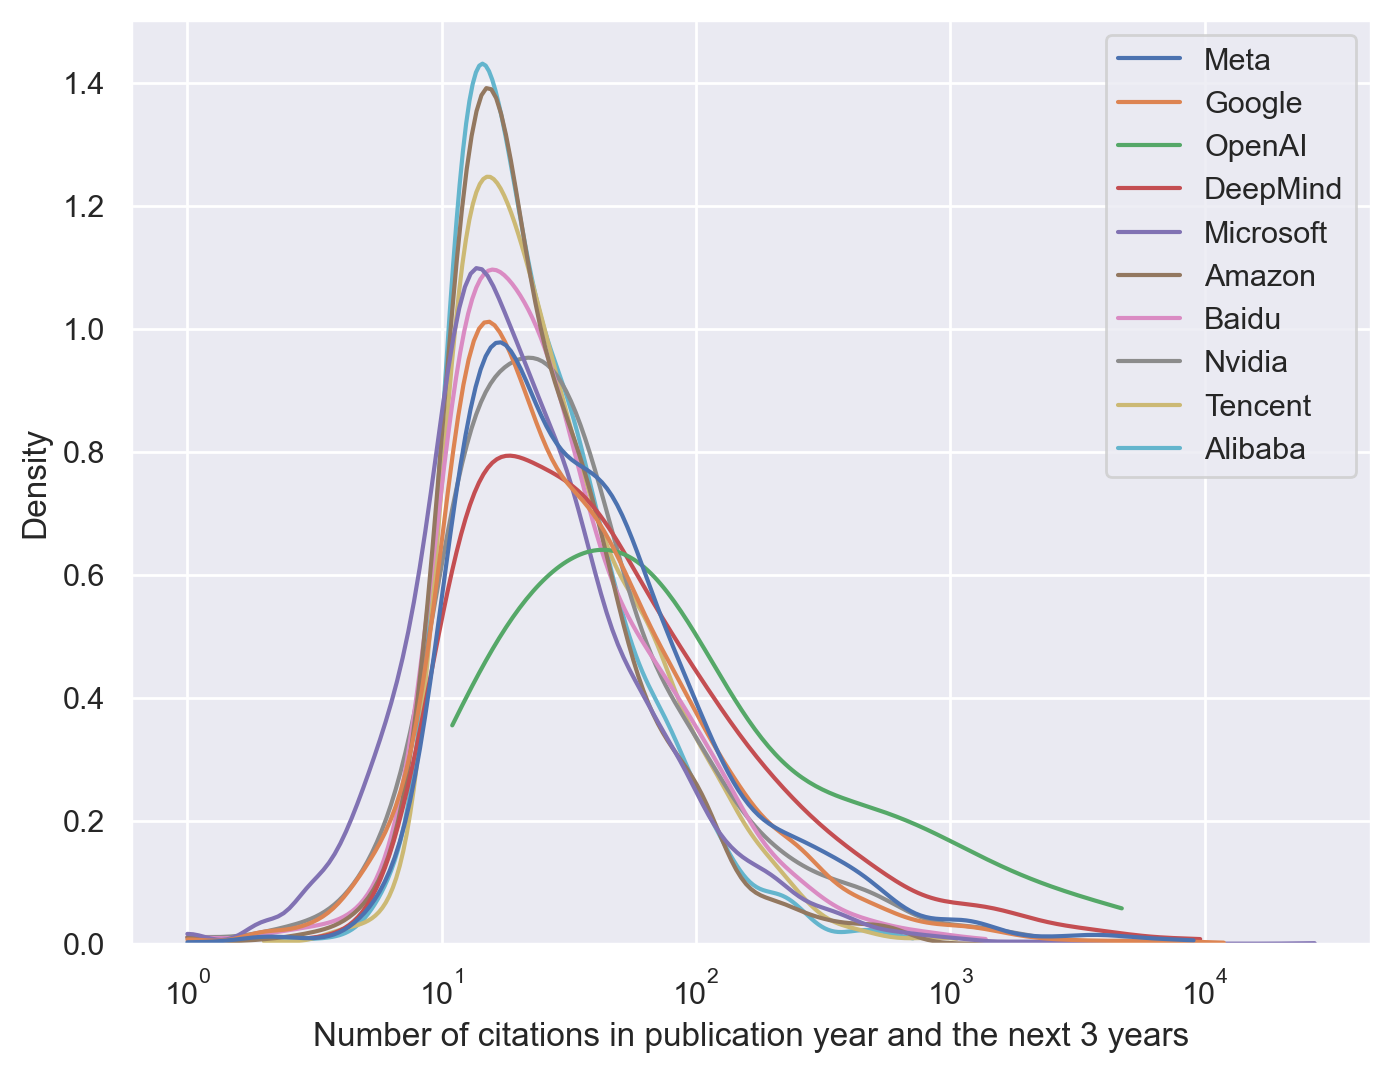

In [52]:
# for ins, cited_by_distribution in institution_cited_by_distribution.items():
plt.figure(figsize=(8, 6), dpi=200)
sns.kdeplot(
    data={
        ins: cited_by_distribution + 1
        for ins, cited_by_distribution in institution_individual_bounded_citations.items()
    },
    log_scale=True,
    common_norm=False,
    cut=0,
)
plt.xlabel('Number of citations in publication year and the next 3 years')

### Field authors

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=total_author_counts['year'],
        y=np.log10(total_author_counts),
        name=get_entity_name(ins),
        mode='lines+markers',
    ),
)

## Plot layout
dates = np.arange(2010, 2022 + 1)
y_ticks = np.arange(0, 101, 10)
y_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# set_default_fig_layout(fig, dates, dates, y_ticks, y_tick_text)

fig.update_layout(
    title='Number of unique authors on AI papers',
    xaxis_title='Year',
    yaxis_title='Number of unique authors',
)

fig.update_layout(
    legend=dict(
        title=">=1 author affiliated with:"
    )
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
# fig.write_image(result_file_location + 'num_authors_google_oai_dm.png', scale=2)

## Show plot
fig.show()

### Field authors

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=ai_concept_cited_by_count.loc[ai_concept_cited_by_count != 0]['year'],
        y=np.log10(np.cumsum(ai_concept_cited_by_count.loc[ai_concept_cited_by_count != 0])),
        mode='lines+markers',
    ),
)

## Plot layout

fig.update_layout(
    title='Cumulative citations for AI works',
    xaxis_title='Year',
    yaxis_title='Cumulative citations (log10)',
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
fig.write_image(result_file_location + 'ai_citations.png', scale=2)

## Show plot
fig.show()

### Authors

In [ ]:
fig = go.Figure()
for ins, author_counts in institution_author_count.items():
    fig.add_trace(
        go.Scatter(
            x=author_counts['year'],
            y=np.log10(author_counts),
            name=get_entity_name(ins),
            mode='lines+markers',
        ),
    )

## Plot layout
dates = np.arange(2010, 2022 + 1)
y_ticks = np.arange(0, 101, 10)
y_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# set_default_fig_layout(fig, dates, dates, y_ticks, y_tick_text)

fig.update_layout(
    title='Number of unique authors on AI/ML works',
    xaxis_title='Year',
    yaxis_title='Number of unique authors (log10)',
)

fig.update_layout(
    legend=dict(
        title="At least one author affiliated with:"
    )
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
# fig.write_image(result_file_location + 'num_authors_log10.png', scale=2)

## Show plot
fig.show()

In [ ]:
total_author_counts = xr.DataArray(np.zeros(13), dims=['year'], coords={'year': np.arange(2010, 2022 + 1)})
for author_counts in institution_author_count.values():
    print(author_counts)
    for count in author_counts:
        total_author_counts.loc[count.year] += count
        # print(year, count)
        # total_author_counts += author_counts
    print(total_author_counts)
    print("====")

In [ ]:
fig = go.Figure()
for ins, cited_by_counts in institution_works_per_author.items():
    sorted_counts = sorted(cited_by_counts.items())
    years = list(zip(*sorted_counts))[0]
    counts = list(zip(*sorted_counts))[1]
    fig.add_trace(
        go.Scatter(
            x=years,
            y=counts,
            name=get_entity_name(ins),
            mode='lines+markers',
        ),
    )

## Plot layout
dates = np.arange(2010, 2022 + 1)
y_ticks = np.arange(0, 101, 10)
y_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# set_default_fig_layout(fig, dates, dates, y_ticks, y_tick_text)

fig.update_layout(
    title='Number of AI/ML works per author',
    xaxis_title='Publication year',
    yaxis_title='Average works per affiliated author',
)

fig.update_layout(
    legend=dict(
        title=">=1 author affiliated with:"
    )
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
# fig.write_image(result_file_location + 'works_per_author.png', scale=2)

## Show plot
fig.show()

### Citations

In [ ]:
fig = go.Figure()
for ins, cited_by_counts in institution_cited_by_counts.items():
    fig.add_trace(
        go.Scatter(
            x=cited_by_counts['year'],
            y=np.log10(cited_by_counts),
            name=get_entity_name(ins),
            mode='lines+markers',
        ),
    )

## Plot layout
dates = np.arange(2010, 2022 + 1)
y_ticks = np.arange(0, 101, 10)
y_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# set_default_fig_layout(fig, dates, dates, y_ticks, y_tick_text)

fig.update_layout(
    title='Number of citations on AI/ML works',
    xaxis_title='Publication year',
    yaxis_title='Total citations in next 3 years (log10)',
)

fig.update_layout(
    legend=dict(
        title=">=1 author affiliated with:"
    )
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
# fig.write_image(result_file_location + 'citations_log10.png', scale=2)

## Show plot
fig.show()

### Citations per work

In [ ]:
fig = go.Figure()
for ins, cited_by_counts in institution_avg_cited_by_counts.items():
    sorted_counts = sorted(cited_by_counts.items())
    years = list(zip(*sorted_counts))[0]
    counts = list(zip(*sorted_counts))[1]
    fig.add_trace(
        go.Scatter(
            x=years,
            y=np.log10(counts),
            name=get_entity_name(ins),
            mode='lines+markers',
        ),
    )

## Plot layout
dates = np.arange(2010, 2022 + 1)
y_ticks = np.arange(0, 101, 10)
y_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# set_default_fig_layout(fig, dates, dates, y_ticks, y_tick_text)

fig.update_layout(
    title='Average number of citations on AI/ML works',
    xaxis_title='Publication year',
    yaxis_title='Average citations in next 3 years (log10)',
)

fig.update_layout(
    legend=dict(
        title=">=1 author affiliated with:"
    )
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
fig.write_image(result_file_location + 'avg_citations_log10.png', scale=2)

## Show plot
fig.show()

### Citations per author

In [ ]:
fig = go.Figure()
for ins, cited_by_counts in institution_cited_by_count_per_author.items():
    sorted_counts = sorted(cited_by_counts.items())
    years = list(zip(*sorted_counts))[0]
    counts = list(zip(*sorted_counts))[1]
    fig.add_trace(
        go.Scatter(
            x=years,
            y=np.log10(counts),
            name=get_entity_name(ins),
            mode='lines+markers',
        ),
    )

## Plot layout
dates = np.arange(2010, 2022 + 1)
y_ticks = np.arange(0, 101, 10)
y_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# set_default_fig_layout(fig, dates, dates, y_ticks, y_tick_text)

fig.update_layout(
    title='Citations per author on AI/ML works',
    xaxis_title='Publication year',
    yaxis_title='Citations in next 3 years, per affiliated author (log10)',
)

fig.update_layout(
    legend=dict(
        title=">=1 author affiliated with:"
    )
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
fig.write_image(result_file_location + 'citations_per_author_log10.png', scale=2)

## Show plot
fig.show()

### Citations per work per author

Note: this is the average number of citations per work, divided by the TOTAL number of authors affiliated with the given organization on all works in the given year.

It is NOT dividing by the number of authors on _each_ work.

In [ ]:
fig = go.Figure()
for ins, cited_by_counts in institution_avg_cited_by_count_per_author.items():
    sorted_counts = sorted(cited_by_counts.items())
    years = list(zip(*sorted_counts))[0]
    counts = list(zip(*sorted_counts))[1]
    fig.add_trace(
        go.Scatter(
            x=years,
            y=np.log10(counts),
            name=get_entity_name(ins),
            mode='lines+markers',
        ),
    )

## Plot layout
dates = np.arange(2010, 2022 + 1)
y_ticks = np.arange(0, 101, 10)
y_tick_text = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# set_default_fig_layout(fig, dates, dates, y_ticks, y_tick_text)

fig.update_layout(
    title='Average citations per author on AI/ML works',
    xaxis_title='Publication year',
    yaxis_title='Average citations in next 3 years, per affiliated author (log10)',
)

fig.update_layout(
    legend=dict(
        title="At least one author affiliated with:"
    )
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
    margin=dict(l=100, r=30, t=80, b=80),
)

## Save plot
fig.write_image(result_file_location + 'avg_citations_per_author_log10.png', scale=2)

## Show plot
fig.show()

# [END]